<a href="https://colab.research.google.com/github/kimkynningsrud/MasterThesis2024/blob/main/code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning using DTW - Master Thesis 2024

To do:
  - Implement metrics for transfer learning from Fadi's paper
  - Implement other functions to measure dataset similarity
  - Make/change model to fine tune outer layer to target dataset
  - Import more datasets.
  - Implement transfer learning classification.
  

What this code does:
  - Imports all datasets and puts them in a dictionary
  - Preprocessing (sets datetime, removing Nan, slicing to relevant timeframe, ensures each ts the same amount of observations etc.)
  - Finds dataset similarity for all datasets (DTW, Cross-correlation, Pearson correlation, MI)
  - Splits all datasets into train and test sets.
  - Creates machine learning models (RNN, MLP) and trains on all train sets and predicts for all test sets.


Questions:
  - As of now, the models use single-source transfer (train on source data, predict on target data). With justification, consider:
    - Possibly use multi-source transfer instead (train model on multiple source datasets)
    - Combine different models trained by one dataset, and finetune it to target, like Fadi's paper. (the MLP model does this, however it is far from done)

## Importing Packages

In [3]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
!pip install dtaidistance
from dtaidistance import dtw
from scipy.spatial.distance import euclidean
import tensorflow as tf
import warnings
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from scipy.signal import correlate
from scipy.stats import pearsonr


warnings.filterwarnings('ignore')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 13.4 MB/s eta 0:00:00


## Importing Data
Here we also make sure the datasets are on the correct format to be able to go through the following functions.

Requirements:
  - Temporal sequence of interest should be in the last column.
  - Column containing data must be named 'Date'

In [4]:
# Stock prices dataset
stock_prices_url = "https://raw.githubusercontent.com/kimkynningsrud/MasterThesis2024/main/data/indexData.csv?token=GHSAT0AAAAAACML34ERF76CZOWCJEXGGYJYZNPUR6A"
stock_prices = pd.read_csv(stock_prices_url)
stock_prices_shenzhen = stock_prices[stock_prices['Index'] == '399001.SZ']
stock_prices_nya = stock_prices[stock_prices['Index'] == 'NYA']
stock_prices_nasdaq = stock_prices[stock_prices['Index'] == 'IXIC']
stock_prices_dax = stock_prices[stock_prices['Index'] == 'GDAXI']
stock_prices_gsptse = stock_prices[stock_prices['Index'] == 'GSPTSE']


# gold prices dataset
gold_prices_url = "https://raw.githubusercontent.com/kimkynningsrud/MasterThesis2024/main/data/Gold%20Price.csv"
gold_prices = pd.read_csv(gold_prices_url)

# petrolium prices dataset
petrolium_prices_url = "https://raw.githubusercontent.com/kimkynningsrud/MasterThesis2024/main/data/PET_PRI_GND_DCUS_NUS_W.csv"
petrolium_prices = pd.read_csv(petrolium_prices_url)

# btc price dataset
btc_prices_url = "https://raw.githubusercontent.com/kimkynningsrud/MasterThesis2024/main/data/BTC-USD.csv"
btc_prices = pd.read_csv(btc_prices_url)

# dollar index value
usdollar_prices_url = "https://raw.githubusercontent.com/kimkynningsrud/MasterThesis2024/main/data/US%20Dollar%20Index%20Historical%20Data.csv"
usdollar_prices = pd.read_csv(usdollar_prices_url)

# unemployment rates
unemployment_rates_url = "https://raw.githubusercontent.com/kimkynningsrud/MasterThesis2024/main/data/df_unemployment_rates.csv"
unemployment_rates = pd.read_csv(unemployment_rates_url)

# microsoft stocks
microsoft_stocks_url = "https://raw.githubusercontent.com/kimkynningsrud/MasterThesis2024/main/data/Microsoft_Stock.csv"
microsoft_stocks = pd.read_csv(microsoft_stocks_url)

yahoo_stocks_url = "https://raw.githubusercontent.com/kimkynningsrud/MasterThesis2024/main/data/yahoo_stock.csv"
yahoo_stocks = pd.read_csv(yahoo_stocks_url)

#other datasets also go here. If the list of datasets grows too long, consider urls in list.


## First basic data exploration

In [5]:
stock_prices.head()
stock_prices['Index'].unique()

array(['NYA', 'IXIC', 'HSI', '000001.SS', 'GSPTSE', '399001.SZ', 'NSEI',
       'GDAXI', 'KS11', 'SSMI', 'TWII', 'J203.JO', 'N225', 'N100'],
      dtype=object)

In [6]:
gold_prices.head()

,Date,Price,Open,High,Low,Volume,Chg%
0,2014-01-01,29542,29435,29598,29340,2930,0.25
1,2014-01-02,29975,29678,30050,29678,3140,1.47
2,2014-01-03,29727,30031,30125,29539,3050,-0.83
3,2014-01-04,29279,29279,29279,29279,0,-1.51
4,2014-01-06,29119,29300,29395,29051,24380,-0.55


In [7]:
# moving the "A1" to the back of the dataframe as this is needed for the DTW. "A1" is the temporal column of interest.
A1col = petrolium_prices.pop("A1")
petrolium_prices.insert(len(petrolium_prices.columns), "A1", A1col)
petrolium_prices.tail()

,Date,A2,A3,R1,R2,R3,M1,M2,M3,P1,P2,P3,D1,A1
1356,12/28/2020,2.225,2.535,2.243,2.158,2.423,2.634,2.482,2.858,2.889,2.770,3.031,2.635,2.330
1357,01/04/2021,2.227,2.549,2.249,2.160,2.437,2.639,2.484,2.867,2.895,2.771,3.042,2.640,2.336
1358,01/11/2021,2.298,2.610,2.317,2.232,2.498,2.702,2.550,2.927,2.959,2.839,3.101,2.670,2.403
1359,01/18/2021,2.351,2.688,2.379,2.285,2.579,2.759,2.601,2.995,3.014,2.885,3.166,2.696,2.464
1360,01/25/2021,2.363,2.703,2.392,2.298,2.593,2.776,2.615,3.014,3.033,2.900,3.191,2.716,2.478


In [8]:
open_p = btc_prices.pop("Open")
btc_prices.insert(len(btc_prices.columns), "Open", open_p)
btc_prices.tail()


,Date,High,Low,Close,Adj Close,Volume,Open
3223,2023-07-15,30407.781250,30263.462891,30295.806641,30295.806641,8011667756,30331.783203
3224,2023-07-16,30437.560547,30089.669922,30249.132813,30249.132813,8516564470,30297.472656
3225,2023-07-17,30336.400391,29685.783203,30145.888672,30145.888672,13240156074,30249.626953
3226,2023-07-18,30233.656250,29556.427734,29856.562500,29856.562500,13138897269,30147.070313
3227,2023-07-20,30224.115234,29918.281250,30189.902344,30189.902344,11906640896,29919.064453


In [9]:
usdprice = usdollar_prices.pop("Price")
usdollar_prices.insert(len(usdollar_prices.columns), "Price", usdprice)
usdollar_prices.tail()

,Date,Open,High,Low,Change %,Price
5618,"Sep 15, 2022",109.60,109.92,109.42,0.19%,109.80
5619,"Sep 16, 2022",109.80,110.26,109.48,-0.14%,109.64
5620,"Sep 18, 2022",109.64,109.74,109.50,-0.08%,109.55
5621,"Sep 19, 2022",109.55,110.18,109.49,-0.01%,109.54
5622,"Sep 20, 2022",109.54,110.23,109.36,0.53%,110.12


In [10]:
overall_rate = unemployment_rates.pop("overall_rate")
unemployment_rates.insert(len(unemployment_rates.columns), "overall_rate", overall_rate)
unemployment_rates = unemployment_rates.rename(columns={'date': 'Date'})
unemployment_rates.tail()

,Date,age_16_17_rate,age_16_19_rate,age_18_19_rate,age_16_24_rate,age_20_24_rate,age_25_34_rate,age_25_54_rate,age_35_44_rate,age_45_54_rate,age_20plus_rate,age_25plus_rate,age_55plus_rate,overall_rate
907,2023-08-01,11.9,12.3,12.7,8.6,7.1,3.9,3.1,3.0,2.5,3.4,3.0,2.7,3.8
908,2023-09-01,12.8,11.8,11.1,8.4,7.0,4.0,3.2,2.8,2.8,3.5,3.0,2.7,3.8
909,2023-10-01,14.7,13.1,12.5,8.8,7.0,4.2,3.2,2.9,2.4,3.5,3.1,2.7,3.8
910,2023-11-01,11.4,11.4,11.5,8.0,6.6,3.9,3.1,2.9,2.6,3.4,3.1,2.9,3.7
911,2023-12-01,13.1,11.9,11.2,8.0,6.4,4.2,3.3,2.9,2.6,3.4,3.2,2.8,3.7


In [11]:
yahoo_stocks.head()

,Date,High,Low,Open,Close,Volume,Adj Close
0,2015-11-23,2095.610107,2081.389893,2089.409912,2086.590088,3.587980e+09,2086.590088
1,2015-11-24,2094.120117,2070.290039,2084.419922,2089.139893,3.884930e+09,2089.139893
2,2015-11-25,2093.000000,2086.300049,2089.300049,2088.870117,2.852940e+09,2088.870117
3,2015-11-26,2093.000000,2086.300049,2089.300049,2088.870117,2.852940e+09,2088.870117
4,2015-11-27,2093.290039,2084.129883,2088.820068,2090.110107,1.466840e+09,2090.110107


In [12]:
microsoft_stocks['Date'] = pd.to_datetime(microsoft_stocks['Date']).dt.date
microsoft_stocks.head()

,Date,Open,High,Low,Close,Volume
0,2015-04-01,40.60,40.76,40.31,40.72,36865322
1,2015-04-02,40.66,40.74,40.12,40.29,37487476
2,2015-04-06,40.34,41.78,40.18,41.55,39223692
3,2015-04-07,41.61,41.91,41.31,41.53,28809375
4,2015-04-08,41.48,41.69,41.04,41.42,24753438


In [13]:
stock_prices_dax.head()

,Index,Date,Open,High,Low,Close,Adj Close,Volume
61436,GDAXI,1987-12-30,1005.190002,1005.190002,1005.190002,1005.190002,1005.190002,0.0
61437,GDAXI,1987-12-31,NaN,NaN,NaN,NaN,NaN,NaN
61438,GDAXI,1988-01-01,NaN,NaN,NaN,NaN,NaN,NaN
61439,GDAXI,1988-01-04,956.489990,956.489990,956.489990,956.489990,956.489990,0.0
61440,GDAXI,1988-01-05,996.099976,996.099976,996.099976,996.099976,996.099976,0.0


In [14]:
datasets = {
    "Shenzhen Stock Index": stock_prices_shenzhen,
    "NYA Stock Index": stock_prices_nya,
    "NASDAQ Stock Index": stock_prices_nasdaq,
    "Gold Prices": gold_prices,
    "Petrolium Prices": petrolium_prices,
    "BTC Prices": btc_prices,
    "US Dollar Index Value": usdollar_prices,
    "Unemployment Rates": unemployment_rates,
    "S&P500 Stocks":yahoo_stocks,
    "Microsoft Stocks":microsoft_stocks,
    "GSPTSE Stock Index":stock_prices_gsptse,
    "DAX Stock Index":stock_prices_dax,
}

## Pre-processing

In [15]:
def convert_dates(df, date_column='Date'):
    """
    Converts the date column to datetime format, relying on Pandas to infer the date format.

    :param df: Pandas DataFrame containing the financial data.
    :param date_column: Name of the column containing date information.
    :return: DataFrame with the converted date column.
    """
    df[date_column] = pd.to_datetime(df[date_column], errors='coerce')
    return df

def trim_dataset_to_timeframe(df, date_column='Date', start_year=2015, end_year=2020):
    """
    Trims the dataset to include data only between the specified start and end years.

    :param dataset: Pandas DataFrame containing the data.
    :param date_column: The name of the column containing the date information.
    :param start_year: The start year for the timeframe.
    :param end_year: The end year for the timeframe.
    :return: Trimmed DataFrame.
    """

    # Filter the dataset based on the date range
    start_date = pd.Timestamp(year=start_year, month=1, day=1)
    end_date = pd.Timestamp(year=end_year, month=12, day=31)
    df = df[(df[date_column] >= start_date) & (df[date_column] <= end_date)]

    return df


def handle_missing_values(df):
    """
    Detects and removes missing values.

    :param df: Pandas DataFrame.
    :return: DataFrame after removing missing values.
    """
    NA_values_before = df.isna().sum().sum()
    df.dropna(inplace=True)
    df.drop_duplicates(inplace=True)
    NA_values_after = df.isna().sum().sum()

    print(f'There are {NA_values_before} NA values in the dataset. {NA_values_after} after removing them.')

    return df

def standardize(df, date_column='Date'):
    """
    Scales numerical columns except the date column.

    :param df: Pandas DataFrame.
    :param date_column: Name of the column containing date information to exclude from scaling.
    :return: Scaled DataFrame.
    """
    scaler = StandardScaler()
    numerical_columns = df.select_dtypes(include=['number']).columns
    numerical_columns = numerical_columns.drop(date_column, errors='ignore')  # Exclude date column if present

    df[numerical_columns] = scaler.fit_transform(df[numerical_columns])

    return df

def trim_to_date_and_last_column(df):
    """
    Keeps only the 'Date' column and the last column in the DataFrame.

    :param df: Pandas DataFrame to trim.
    :return: Trimmed DataFrame with only the 'Date' column and the last data column.
    """
    if 'Date' in df.columns and len(df.columns) > 1:
        # Selecting only the 'Date' column and the last column of the DataFrame
        return df[['Date', df.columns[-1]]]
    else:
        print("Error: DataFrame must contain a 'Date' column and at least one other column.")
        return None  # Returning None to indicate that the required condition is not met



def normalize_minmax(df, columns=None):
    """
    Normalizes the specified columns of a DataFrame using Min-Max scaling.

    :param df: DataFrame to be normalized.
    :param columns: List of column names to normalize. If None, all numeric columns will be normalized.
    :return: DataFrame with normalized columns.
    """
    scaler = MinMaxScaler()
    if columns is None:
        columns = df.select_dtypes(include=['number']).columns
    df[columns] = scaler.fit_transform(df[columns])
    return df


def stationarize_columns(df):
    """
    Processes each numeric column in the DataFrame by checking for stationarity
    and making it stationary if needed.

    :param df: DataFrame containing the time series data.
    :return: DataFrame with all necessary columns processed for stationarity.
    """
    for column in df.select_dtypes(include=['number']).columns:
        print(f"Processing column: {column}")

        # Check for stationarity
        series = df[column]
        result = adfuller(series, autolag='AIC')
        p_value = result[1]

        if p_value < 0.05:
            print(f"Column {column} is already stationary")
        else:
            # Make the series stationary if not stationary
            print(f"Making column {column} stationary")
            df[column] = df[column].diff().dropna()

    return df

def resample_to_daily(df, date_column='Date', start_year=2015, end_year=2020):
    """
    Resamples the DataFrame to have an observation for every day between the specified start and end years.
    Fills missing observations at the start and end of a year.

    :param df: DataFrame to resample.
    :param date_column: Name of the date column.
    :param start_year: Start year for the observations.
    :param end_year: End year for the observations.
    :return: DataFrame resampled to daily frequency with complete coverage over specified years.
    """
    df = df.set_index(date_column)

    # Generate a complete date range from start to end years
    start_date = pd.Timestamp(year=start_year, month=1, day=1)
    end_date = pd.Timestamp(year=end_year, month=12, day=31)
    full_date_range = pd.date_range(start=start_date, end=end_date)

    # Reindex the DataFrame to ensure it covers the full date range, using forward fill to handle missing dates
    df = df.reindex(full_date_range).interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')

    return df.reset_index().rename(columns={'index': date_column})

def preprocess_datasets(datasets, scaled, start_year=2015, end_year=2020):
    """
    Preprocesses datasets to ensure daily observations for every date within the given years.
    Applies conversion to datetime, trims datasets, handles missing values, optionally scales,
    and ensures complete daily frequency coverage.

    :param datasets: A dictionary of datasets.
    :param scaled: Boolean to indicate whether datasets should be scaled.
    :param start_year: Start year for the observations.
    :param end_year: End year for the observations.
    :return: Dictionary of preprocessed datasets.
    """

    preprocessed_datasets = {}

    for name, df in datasets.items():
        print("_________________________________________________")
        print(f"Preprocessing {name}")
        preprocessed_df = convert_dates(df)
        preprocessed_df = trim_to_date_and_last_column(preprocessed_df)
        preprocessed_df = handle_missing_values(preprocessed_df)
        preprocessed_df = trim_dataset_to_timeframe(preprocessed_df, start_year=start_year, end_year=end_year)
        preprocessed_df = resample_to_daily(preprocessed_df, 'Date', start_year=start_year, end_year=end_year)
        if scaled:
            preprocessed_df = normalize_minmax(preprocessed_df)

        preprocessed_datasets[name] = preprocessed_df

    return preprocessed_datasets



In [16]:
# Preprocess all datasets
preprocessed_datasets = preprocess_datasets(datasets, scaled=True)

_________________________________________________
Preprocessing Shenzhen Stock Index
There are 168 NA values in the dataset. 0 after removing them.
_________________________________________________
Preprocessing NYA Stock Index
There are 1 NA values in the dataset. 0 after removing them.
_________________________________________________
Preprocessing NASDAQ Stock Index
There are 0 NA values in the dataset. 0 after removing them.
_________________________________________________
Preprocessing Gold Prices
There are 0 NA values in the dataset. 0 after removing them.
_________________________________________________
Preprocessing Petrolium Prices
There are 0 NA values in the dataset. 0 after removing them.
_________________________________________________
Preprocessing BTC Prices
There are 0 NA values in the dataset. 0 after removing them.
_________________________________________________
Preprocessing US Dollar Index Value
There are 0 NA values in the dataset. 0 after removing them.
_____

In [17]:
list(preprocessed_datasets.items())[9]

('Microsoft Stocks',
            Date    Volume
 0    2015-01-01  0.272071
 1    2015-01-02  0.272071
 2    2015-01-03  0.272071
 3    2015-01-04  0.272071
 4    2015-01-05  0.272071
 ...         ...       ...
 2187 2020-12-27  0.118306
 2188 2020-12-28  0.131965
 2189 2020-12-29  0.128041
 2190 2020-12-30  0.149274
 2191 2020-12-31  0.154231
 
 [2192 rows x 2 columns])

## Plotting after preprocessing

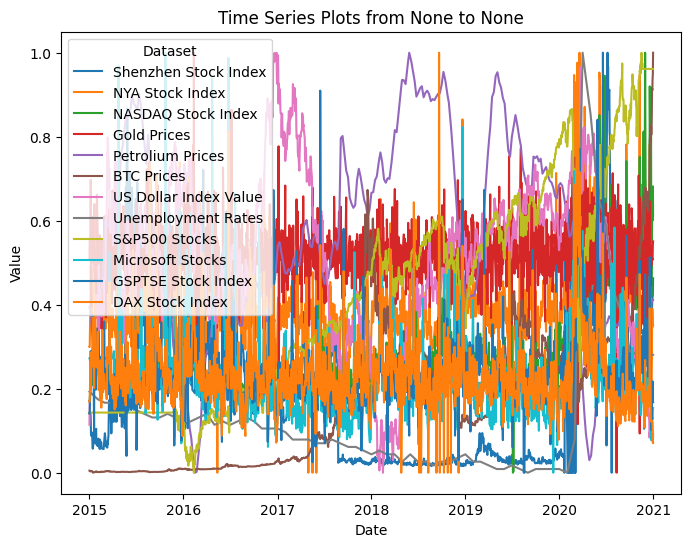

In [18]:
def plot_datasets(datasets, start_year=None, end_year=None):
    """
    Plots each dataset within the specified year range on the same plot with 'Date' on the x-axis and
    the last column on the y-axis.

    :param datasets: Dictionary of preprocessed datasets with their names as keys.
    :param start_year: The starting year for the plots (inclusive).
    :param end_year: The ending year for the plots (inclusive).
    """
    plt.figure(figsize=(8, 6))

    for name, df in datasets.items():
        # Filter based on the specified year range if provided
        if start_year is not None and end_year is not None:
            mask = (df['Date'].dt.year >= start_year) & (df['Date'].dt.year <= end_year)
            filtered_df = df.loc[mask]
        else:
            filtered_df = df

        if not filtered_df.empty:
            last_column = filtered_df.columns[-1]  # Assuming the last column is the one to be plotted
            sns.lineplot(data=filtered_df, x='Date', y=last_column, label=name)  # Plot each dataset

    plt.title(f"Time Series Plots from {start_year} to {end_year}")
    plt.xlabel("Date")
    plt.ylabel("Value")
    plt.legend(title='Dataset')
    plt.show()

plot_datasets(preprocessed_datasets)

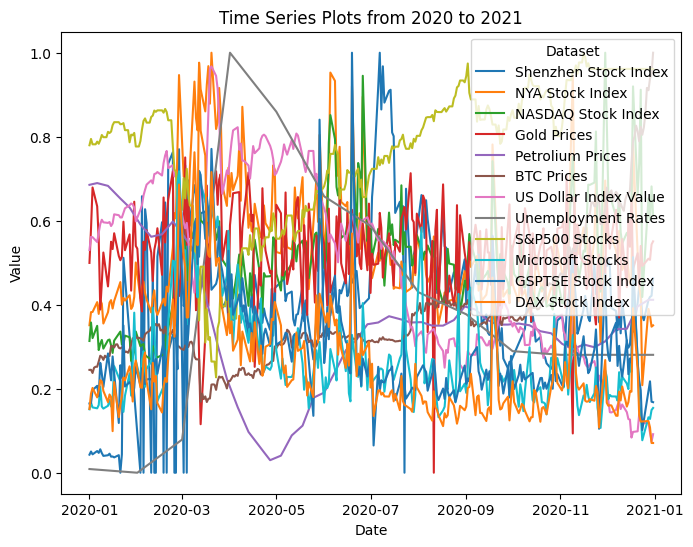

In [19]:
plot_datasets(preprocessed_datasets, start_year=2020, end_year=2021)

## Time series Similarities

### Dynamic Time Warping (DTW)

In [20]:
def compare_datasets_with_dtw(datasets, plot_alignments=False):
    """
    Compares each dataset to every other dataset using Dynamic Time Warping (DTW).
    Assumes the column of interest is the last one in each dataset. Optionally plots the alignments.

    :param datasets: Dictionary of Pandas DataFrames, each representing a time series dataset.
    :param plot_alignments: Boolean, whether to plot the time series alignments.
    :return: A DataFrame of DTW distances between each pair of datasets.
    """
    # Extract the last column from each dataset
    sequences = [df.iloc[:, -1].values for df in datasets.values()]

    # Compute the DTW distance matrix
    distance_matrix = dtw.distance_matrix_fast(sequences)

    dataset_names = list(datasets.keys())
    return pd.DataFrame(distance_matrix, index=dataset_names, columns=dataset_names)

# Use the function on the preprocessed datasets and plot alignments
dtw_df = compare_datasets_with_dtw(preprocessed_datasets, plot_alignments=True)


### Cross-correlation

In [21]:
def compare_datasets_with_cross_correlation(datasets):
    """
    Compares each dataset to every other dataset using cross-correlation.
    Assumes the column of interest is the last one in each dataset.

    :param datasets: Dictionary of Pandas DataFrames, each representing a time series dataset.
    :return: A DataFrame of cross-correlation scores between each pair of datasets.
    """
    dataset_names = list(datasets.keys())
    n = len(dataset_names)
    cross_corr_matrix = np.zeros((n, n))

    for i in range(n):
        for j in range(i + 1, n):
            # Extract the last column from each dataset for comparison
            series_i = datasets[dataset_names[i]].iloc[:, -1]
            series_j = datasets[dataset_names[j]].iloc[:, -1]

            # Compute cross-correlation
            corr = correlate(series_i, series_j, mode='full')
            max_corr = np.max(corr)
            cross_corr_matrix[i, j] = cross_corr_matrix[j, i] = max_corr

    return pd.DataFrame(cross_corr_matrix.round(2), index=dataset_names, columns=dataset_names)

cross_corr_df = compare_datasets_with_cross_correlation(preprocessed_datasets)

### Pearson correlation

In [22]:
def compute_pearson_matrix(preprocessed_datasets):
    # Extract dataset names
    dataset_names = list(preprocessed_datasets.keys())
    n = len(dataset_names)

    # Initialize the matrix with NaNs
    correlation_matrix = np.full((n, n), np.nan)

    # Compute Pearson correlation for each unique pair
    for i in range(n):
        for j in range(i+1, n):  # Compute only for unique pairs and avoid self-comparison
            # Extract the column of interest (second column) from each dataset
            data1 = preprocessed_datasets[dataset_names[i]].iloc[:, 1]
            data2 = preprocessed_datasets[dataset_names[j]].iloc[:, 1]

            # Compute Pearson correlation coefficient
            corr, _ = pearsonr(data1, data2)

            # Fill the matrix
            correlation_matrix[j, i] = corr

    # Convert the matrix to a pandas DataFrame for better readability
    return pd.DataFrame(correlation_matrix, index=dataset_names, columns=dataset_names)

pearson_correlation_df = compute_pearson_matrix(preprocessed_datasets)


### Mutual Information

In [23]:
from sklearn.feature_selection import mutual_info_regression
import numpy as np
import pandas as pd

def compute_mutual_information_matrix(preprocessed_datasets):
    # Extract dataset names
    dataset_names = list(preprocessed_datasets.keys())
    n = len(dataset_names)

    # Initialize the matrix
    mi_matrix = np.zeros((n, n))

    # Compute Mutual Information for each unique pair
    for i in range(n):
        for j in range(i, n):  # Include self-comparison since MI with self is not always 0
            # Extract the column of interest (second column) from each dataset
            data1 = preprocessed_datasets[dataset_names[i]].iloc[:, 1]
            data2 = preprocessed_datasets[dataset_names[j]].iloc[:, 1]

            if i == j:
                # Mutual information of a variable with itself can be computed as the entropy of the variable
                mi = mutual_info_regression(data1.to_frame(), data1)[0]
            else:
                # Compute Mutual Information between the two different datasets
                mi = mutual_info_regression(data1.to_frame(), data2)[0]

            # Fill the matrix
            mi_matrix[j, i] = mi

    # Convert the matrix to a pandas DataFrame for better readability
    return pd.DataFrame(mi_matrix, index=dataset_names, columns=dataset_names)

mi_matrix_df = compute_mutual_information_matrix(preprocessed_datasets)


### Plots

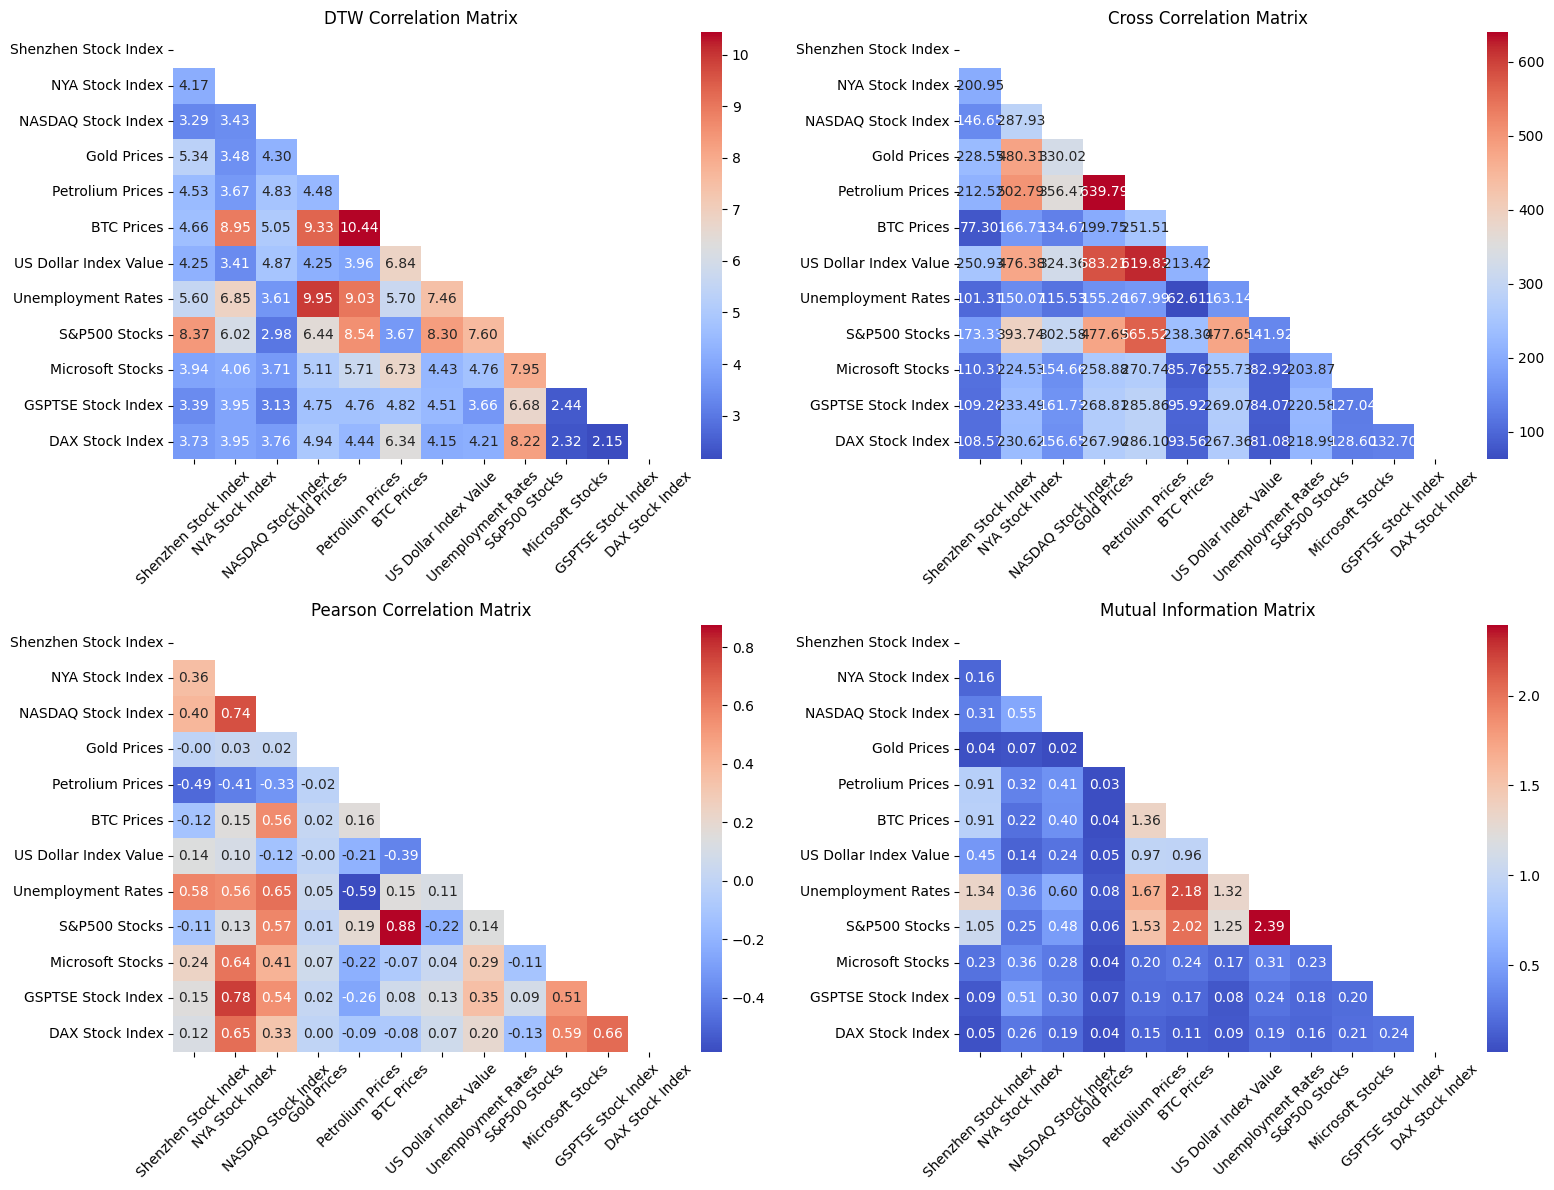

In [24]:
# Set up the matplotlib figure with a 2x2 grid
fig, axs = plt.subplots(2, 2, figsize=(16, 12))
mask = np.triu(np.ones_like(dtw_df, dtype=bool))

# Adjust the whitespace between plots
plt.subplots_adjust(wspace=0.5, hspace=0.5)

# Define the rotation angle for x-axis labels
rotation_angle = 45

# Plot the first correlation matrix (DTW)
sns.heatmap(dtw_df, ax=axs[0, 0], fmt=".2f", annot=True, cmap='coolwarm', cbar=True, mask=mask)
axs[0, 0].set_title('DTW Correlation Matrix')
axs[0, 0].set_xticklabels(axs[0, 0].get_xticklabels(), rotation=rotation_angle)

# Plot the second correlation matrix (Cross Correlation)
sns.heatmap(cross_corr_df, ax=axs[0, 1], fmt=".2f", annot=True, cmap='coolwarm', cbar=True, mask=mask)
axs[0, 1].set_title('Cross Correlation Matrix')
axs[0, 1].set_xticklabels(axs[0, 1].get_xticklabels(), rotation=rotation_angle)

# Plot the third correlation matrix (Pearson)
sns.heatmap(pearson_correlation_df, ax=axs[1, 0], fmt=".2f", annot=True, cmap='coolwarm', cbar=True, mask=mask)
axs[1, 0].set_title('Pearson Correlation Matrix')
axs[1, 0].set_xticklabels(axs[1, 0].get_xticklabels(), rotation=rotation_angle)

# Plot the fourth correlation matrix (Mutual Information)
sns.heatmap(mi_matrix_df, ax=axs[1, 1], fmt=".2f", annot=True, cmap='coolwarm', cbar=True, mask=mask)
axs[1, 1].set_title('Mutual Information Matrix')
axs[1, 1].set_xticklabels(axs[1, 0].get_xticklabels(), rotation=rotation_angle)

plt.tight_layout() # Adjust layout to make room for the rotated x-axis labels
plt.show()


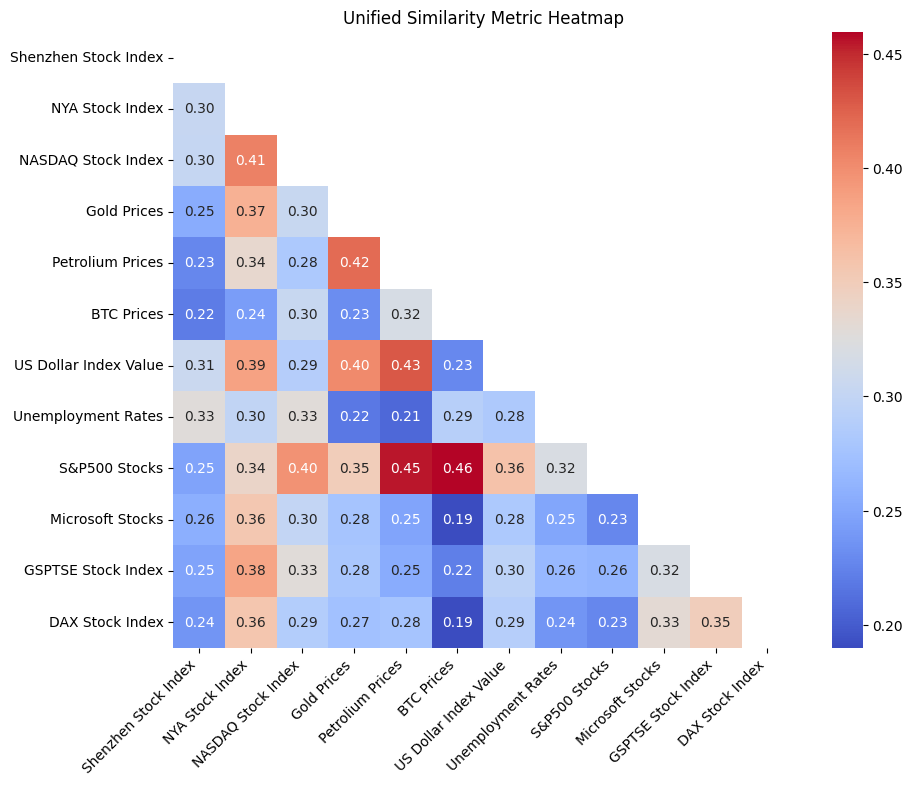

In [25]:

# Normalize DTW (lower is better, so we invert it)
# Assuming DTW values are all positive; if they can be zero, add a small constant to avoid division by zero
dtw_normalized = 1 / (1 + dtw_df)

# Normalize Cross Correlation (higher absolute values are better)
# Here we assume all values are positive; if not, take the absolute value before normalization
cross_corr_normalized = cross_corr_df / cross_corr_df.max().max()

# Normalize Pearson Correlation (scale of -1 to 1, convert to 0 to 1)
pearson_normalized = (pearson_correlation_df + 1) / 2

# Normalize Mutual Information (higher is better)
# Assuming MI values are all positive
mi_normalized = mi_matrix_df / mi_matrix_df.max().max()

# Combine normalized metrics by averaging them
unified_metric_df = (dtw_normalized + cross_corr_normalized + pearson_normalized + mi_normalized) / 4


plt.figure(figsize=(10, 8))
sns.heatmap(unified_metric_df, annot=True, fmt=".2f", cmap='coolwarm')
plt.xticks(rotation=45, ha='right')
plt.title('Unified Similarity Metric Heatmap')
plt.show()

## Test-Train split

In [26]:
train_sets = {}
test_sets = {}

# Splitting logic
for dataset_name, df in preprocessed_datasets.items():

    # Find the cutoff date for the last year (the latest date in the dataset minus one year)
    cutoff_date = df['Date'].max() - pd.DateOffset(years=1)

    # Split the dataset into training and testing sets
    train_df = df[df['Date'] <= cutoff_date]
    test_df = df[df['Date'] > cutoff_date]

    # Store the split datasets
    train_sets[dataset_name] = train_df
    test_sets[dataset_name] = test_df


## Normal RNN Model (No TL)

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from keras.models import Sequential
from keras.layers import LSTM, Dense
import math

# Initialize a table to store the evaluation metrics
evaluation_table_no_TL = pd.DataFrame(columns=['Dataset', 'MAE', 'RMSE', 'CTSFP'])

# Function to reshape data for LSTM input
def reshape_data(data):
    return data.reshape((data.shape[0], 1, data.shape[1]))

# Loop over each dataset
for dataset_name, train_data in train_sets.items():
    test_data = test_sets[dataset_name]

    # Assuming the last column is the target variable
    X_train = train_data.iloc[:, :-1].values
    y_train = train_data.iloc[:, -1].values
    X_test = test_data.iloc[:, :-1].values
    y_test = test_data.iloc[:, -1].values

    # Scale the features
    scaler = MinMaxScaler(feature_range=(0, 1))
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Reshape input to be 3D [samples, timesteps, features] for LSTM
    X_train_scaled = reshape_data(X_train_scaled)
    X_test_scaled = reshape_data(X_test_scaled)

    # Define the LSTM model
    model = Sequential()
    model.add(LSTM(50, input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2])))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')

    # Fit model
    model.fit(X_train_scaled, y_train, epochs=50, batch_size=72, validation_data=(X_test_scaled, y_test), verbose=2, shuffle=False)

    # Predict
    y_pred = model.predict(X_test_scaled)

    # Inverse scale if necessary (not shown here, depends on your data)
    # Calculate MAE and RMSE
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    ctsfp = np.sqrt(rmse**2 + mae**2)

    # Append the results to the evaluation table
    evaluation_table_no_TL = evaluation_table_no_TL.append({'Dataset': dataset_name, 'MAE': mae, 'RMSE': rmse, 'CTSFP': ctsfp}, ignore_index=True)


Epoch 1/50
26/26 - 9s - loss: 0.0454 - val_loss: 0.1354 - 9s/epoch - 357ms/step
Epoch 2/50
26/26 - 0s - loss: 0.0352 - val_loss: 0.1160 - 226ms/epoch - 9ms/step
Epoch 3/50
26/26 - 0s - loss: 0.0305 - val_loss: 0.1203 - 210ms/epoch - 8ms/step
Epoch 4/50
26/26 - 0s - loss: 0.0275 - val_loss: 0.1307 - 209ms/epoch - 8ms/step
Epoch 5/50
26/26 - 0s - loss: 0.0249 - val_loss: 0.1429 - 266ms/epoch - 10ms/step
Epoch 6/50
26/26 - 0s - loss: 0.0226 - val_loss: 0.1567 - 235ms/epoch - 9ms/step
Epoch 7/50
26/26 - 0s - loss: 0.0205 - val_loss: 0.1720 - 256ms/epoch - 10ms/step
Epoch 8/50
26/26 - 0s - loss: 0.0186 - val_loss: 0.1882 - 248ms/epoch - 10ms/step
Epoch 9/50
26/26 - 0s - loss: 0.0170 - val_loss: 0.2045 - 192ms/epoch - 7ms/step
Epoch 10/50
26/26 - 0s - loss: 0.0158 - val_loss: 0.2201 - 241ms/epoch - 9ms/step
Epoch 11/50
26/26 - 0s - loss: 0.0148 - val_loss: 0.2342 - 217ms/epoch - 8ms/step
Epoch 12/50
26/26 - 0s - loss: 0.0142 - val_loss: 0.2461 - 223ms/epoch - 9ms/step
Epoch 13/50
26/26 - 0s 

In [ ]:
evaluation_table_no_TL

## MLP (if time permits)

## RNN Models with evaluation from Fadi's paper

In [ ]:
preprocessed_datasets = preprocess_datasets(datasets, scaled=False)

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam


def prepare_data(df, temporal_column, split_ratio=0.8):
    scaler = MinMaxScaler()
    data_scaled = scaler.fit_transform(df[[temporal_column]])

    split_idx = int(len(data_scaled) * split_ratio)
    train, test = data_scaled[:split_idx], data_scaled[split_idx:]

    # Convert to [samples, time steps, features]
    def create_dataset(data, look_back=1):
        X, Y = [], []
        for i in range(len(data) - look_back - 1):
            a = data[i:(i + look_back), 0]
            X.append(a)
            Y.append(data[i + look_back, 0])
        return np.array(X), np.array(Y)

    look_back = 1  # Using single step for simplicity
    X_train, Y_train = create_dataset(train, look_back)
    X_test, Y_test = create_dataset(test, look_back)

    # Reshape input to be [samples, time steps, features]
    X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
    X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

    return X_train, Y_train, X_test, Y_test, scaler

def build_model():
    model = Sequential([
        # Input LSTM layer with return_sequences=True for stacking
        LSTM(50, input_shape=(1, 1), return_sequences=True),
        Dropout(0.2),
        LSTM(100, return_sequences=False),
        Dropout(0.2),
        Dense(50, activation='relu'),
        Dense(1)  # Output layer remains the same
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
    return model

def compute_ctsfp(mae, rmse):
    return np.sqrt(mae**2 + rmse**2)

perf1_results = {}

for name, df in preprocessed_datasets.items():
    temporal_column = df.columns[1]
    X_train, Y_train, X_test, Y_test, scaler = prepare_data(df, temporal_column)

    model = build_model()
    model.fit(X_train, Y_train, epochs=20, batch_size=32)

    predictions = model.predict(X_test)
    predictions = scaler.inverse_transform(predictions)
    Y_test = scaler.inverse_transform([Y_test])

    mae = mean_absolute_error(Y_test[0], predictions[:, 0])
    rmse = np.sqrt(mean_squared_error(Y_test[0], predictions[:, 0]))
    ctsfp = compute_ctsfp(mae, rmse)

    perf1_results[name] = ctsfp

print(perf1_results)


In [ ]:
import copy
def fine_tune_model(model, X_train, Y_train):
    """
    Fine-tunes an existing model with new training data.
    """
    # Get a copy of the weights before fine-tuning for comparison
    weights_before = model.get_weights()

    # Fine-tuning the model
    model.fit(X_train, Y_train, epochs=5, batch_size=32)

    # Get the weights after fine-tuning
    weights_after = model.get_weights()

    # Calculate the sum of absolute differences between the weights
    weight_changes = [np.sum(np.abs(w2 - w1)) for w1, w2 in zip(weights_before, weights_after)]
    total_change = np.sum(weight_changes)

    # Check if the weights have changed significantly
    if total_change == 0:
        print("Warning: Weights did not change during fine-tuning.")
    else:
        print(f"Weights changed by a total sum of {total_change} during fine-tuning.")

    return model

def evaluate_model(model, X_test, Y_test, scaler):
    """
    Evaluates the model on the test set and computes MAE, RMSE, and CTSFP.
    """
    predictions = model.predict(X_test)
    predictions = scaler.inverse_transform(predictions)
    Y_test = scaler.inverse_transform([Y_test])

    mae = mean_absolute_error(Y_test[0], predictions[:, 0])
    rmse = np.sqrt(mean_squared_error(Y_test[0], predictions[:, 0]))
    ctsfp = compute_ctsfp(mae, rmse)

    return ctsfp

# Initialize dictionaries to store the results for each scenario
perf2_results = {}
perf3_results = {}
perf4_results = {}

# Loop through all combinations of source and target datasets
for source_name, source_df in preprocessed_datasets.items():
    temporal_column_source = source_df.columns[1]  # Assuming the second column is temporal
    X_train_source, Y_train_source, X_test_source, Y_test_source, scaler_source = prepare_data(source_df, temporal_column_source)

    model_source = build_model()
    model_source.fit(X_train_source, Y_train_source, epochs=20, batch_size=32)

    for target_name, target_df in preprocessed_datasets.items():
        if source_name == target_name:
            continue  # Skip evaluating on the same dataset

        temporal_column_target = target_df.columns[1]  # Assuming the second column is temporal
        X_train_target, Y_train_target, X_test_target, Y_test_target, scaler_target = prepare_data(target_df, temporal_column_target)

        # Scenario 2: Fine-tune and evaluate
        model_finetuned = copy.deepcopy(model_source)
        model_finetuned = fine_tune_model(model_finetuned, X_train_target, Y_train_target)
        perf2 = evaluate_model(model_finetuned, X_test_target, Y_test_target, scaler_target)
        perf2_results[(source_name, target_name)] = perf2

        # Scenario 3: Direct evaluation of source model on target test data
        perf3 = evaluate_model(model_source, X_test_target, Y_test_target, scaler_target)
        perf3_results[(source_name, target_name)] = perf3

        # Scenario 4: Evaluate fine-tuned model on source test data
        perf4 = evaluate_model(model_finetuned, X_test_source, Y_test_source, scaler_source)
        perf4_results[(source_name, target_name)] = perf4

print("Perf2 Results:", perf2_results)
print("Perf3 Results:", perf3_results)
print("Perf4 Results:", perf4_results)


In [ ]:
# Initialize a dictionary to store the results for perf5
perf5_results = {}

# Loop through all target datasets to train a new model from scratch and evaluate
for target_name, target_df in preprocessed_datasets.items():
    temporal_column_target = target_df.columns[1]  # Assuming the second column is temporal
    X_train_target, Y_train_target, X_test_target, Y_test_target, scaler_target = prepare_data(target_df, temporal_column_target)

    # Train a new model from scratch on the target dataset
    model_new = build_model()
    model_new.fit(X_train_target, Y_train_target, epochs=20, batch_size=32)

    # Evaluate the newly trained model on the target test data
    perf5 = evaluate_model(model_new, X_test_target, Y_test_target, scaler_target)
    perf5_results[target_name] = perf5

print("Perf5 Results:", perf5_results)


## TL Performance Metrics

This is the implementation of the metrics in Fadi's paper. These metrics are:
- Transfer Learning Gain (TGL)
- Refrence Generalization Ratio (RGR)
- Transfer Learning Forgetting Ratio (TLFR)
- Transfer Learning Generalization Gain (TLGG)

To display this, one would need one table for each metric.

In [ ]:
import numpy as np
import seaborn as sns

# Assuming the same mock results, but we'll transform them into a matrix form for heat map visualization
datasets = preprocessed_datasets.keys()
# Initialize matrices to hold the metrics for heat maps
tlg_matrix = np.zeros((len(datasets), len(datasets)))
rgr_matrix = np.zeros((len(datasets), len(datasets)))
tlfr_matrix = np.zeros((len(datasets), len(datasets)))
tlgg_matrix = np.zeros((len(datasets), len(datasets)))

# Populate the matrices
for i, source in enumerate(datasets):
    for j, target in enumerate(datasets):
        if source == target:
            continue  # Skip the diagonal where source and target are the same
        tlg_matrix[i, j] = perf2_results.get((source, target), np.nan) / perf5_results.get(target, np.nan)
        rgr_matrix[i, j] = perf3_results.get((source, target), np.nan) / perf1_results.get(source, np.nan)
        tlfr_matrix[i, j] = perf4_results.get((source, target), np.nan) / perf1_results.get(source, np.nan)
        tlgg_matrix[i, j] = perf2_results.get((source, target), np.nan) / perf3_results.get((source, target), np.nan)

fig, axs = plt.subplots(2, 2, figsize=(16, 12))

# TLG Heat Map
sns.heatmap(tlg_matrix, annot=True, ax=axs[0, 0], cmap="YlGnBu", cbar=True, xticklabels=datasets, yticklabels=datasets)
axs[0, 0].set_title('Transfer Learning Gain (TLG)')
axs[0, 0].set_xlabel('Target Dataset')
axs[0, 0].set_ylabel('Source Dataset')

# RGR Heat Map
sns.heatmap(rgr_matrix, annot=True, ax=axs[0, 1], cmap="YlGnBu", fmt=".0f", cbar=True, xticklabels=datasets, yticklabels=datasets, annot_kws={"size": 5})
axs[0, 1].set_title('Reference Generalization Ratio (RGR)')
axs[0, 1].set_xlabel('Target Dataset')
axs[0, 1].set_ylabel('Source Dataset')

# TLFR Heat Map
sns.heatmap(tlfr_matrix, annot=True, ax=axs[1, 0], cmap="YlGnBu", cbar=True, xticklabels=datasets, yticklabels=datasets)
axs[1, 0].set_title('Transfer Learning Forgetting Ratio (TLFR)')
axs[1, 0].set_xlabel('Target Dataset')
axs[1, 0].set_ylabel('Source Dataset')

# TLGG Heat Map
sns.heatmap(tlgg_matrix, annot=True, ax=axs[1, 1], cmap="YlGnBu", cbar=True, xticklabels=datasets, yticklabels=datasets)
axs[1, 1].set_title('Transfer Learning Generalization Gain (TLGG)')
axs[1, 1].set_xlabel('Target Dataset')
axs[1, 1].set_ylabel('Source Dataset')

plt.tight_layout()
plt.show()


In [ ]:

# Display perf1 results
print("Performance 1 (Baseline on each dataset):")
for dataset, performance in perf1_results.items():
    print(f"{dataset}: CTSFP = {performance}")

# Display perf2 results
print("\nPerformance 2 (Fine-tuning on target dataset):")
for (source, target), performance in perf2_results.items():
    print(f"Source: {source}, Target: {target}: CTSFP = {performance}")

# Display perf3 results
print("\nPerformance 3 (Direct evaluation on target dataset):")
for (source, target), performance in perf3_results.items():
    print(f"Source: {source}, Target: {target}: CTSFP = {performance}")

# Display perf4 results
print("\nPerformance 4 (Evaluation of fine-tuned model on source test data):")
for (source, target), performance in perf4_results.items():
    print(f"Source: {source}, Target: {target}: CTSFP = {performance}")

# Display perf5 results
print("\nPerformance 5 (Training from scratch on target dataset):")
for dataset, performance in perf5_results.items():
    print(f"{dataset}: CTSFP = {performance}")


In [ ]:
datasets = list(perf1_results.keys())

# Creating a DataFrame to hold all perf results for easier plotting
data = {
    "Dataset": [],
    "Performance": [],
    "Scenario": []
}

# Adding perf1 results
for dataset, perf in perf1_results.items():
    data["Dataset"].append(dataset)
    data["Performance"].append(perf)
    data["Scenario"].append("Perf1")

# Adding perf5 results
for dataset, perf in perf5_results.items():
    data["Dataset"].append(dataset)
    data["Performance"].append(perf)
    data["Scenario"].append("Perf5")

# Perf2, Perf3, and Perf4 are related to transfers; we simplify this for visualization
# We will average the performance for scenarios involving transfers for each dataset
for dataset in datasets:
    perf2_avg = np.mean([perf for (src, tgt), perf in perf2_results.items() if src == dataset or tgt == dataset])
    perf3_avg = np.mean([perf for (src, tgt), perf in perf3_results.items() if src == dataset or tgt == dataset])
    perf4_avg = np.mean([perf for (src, tgt), perf in perf4_results.items() if src == dataset or tgt == dataset])

    data["Dataset"] += [dataset] * 3
    data["Performance"] += [perf2_avg, perf3_avg, perf4_avg]
    data["Scenario"] += ["Perf2 (Avg)", "Perf3 (Avg)", "Perf4 (Avg)"]

df = pd.DataFrame(data)

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(x="Dataset", y="Performance", hue="Scenario", data=df)
plt.title('Performance Across Scenarios')
plt.ylabel('Performance (CTSFP)')
plt.xlabel('Dataset')
plt.xticks(rotation=45)
plt.legend(title='Scenario', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

plt.show()

## TL Classification

In [ ]:
preprocessed_datasets = preprocess_datasets(datasets, scaled=True)

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import copy


def create_dataset(data, look_back=1):
    X, Y = [], []
    for i in range(len(data) - look_back):
        a = data[i:(i + look_back), 0]
        X.append(a)
        Y.append(1 if data[i + look_back, 0] > data[i + look_back - 1, 0] else 0)
    return np.array(X), np.array(Y)

def prepare_data(df, temporal_column, split_ratio=0.8):
    scaler = MinMaxScaler()
    data_scaled = scaler.fit_transform(df[[temporal_column]])

    split_idx = int(len(data_scaled) * split_ratio)
    train, test = data_scaled[:split_idx], data_scaled[split_idx:]

    look_back = 1
    X_train, Y_train = create_dataset(train, look_back)
    X_test, Y_test = create_dataset(test, look_back)

    X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
    X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

    return X_train, Y_train, X_test, Y_test, scaler

def build_model():
    model = Sequential([
        LSTM(50, input_shape=(1, 1), return_sequences=True),
        Dropout(0.2),
        LSTM(100, return_sequences=False),
        Dropout(0.2),
        Dense(50, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(learning_rate=0.1), loss='binary_crossentropy', metrics=['accuracy'])
    return model

from sklearn.metrics import f1_score
def evaluate_model(model, X_test, Y_test):
    predictions = model.predict(X_test)
    predictions = (predictions > 0.5).astype(int)
    accuracy = f1_score(Y_test, predictions[:, 0])
    return accuracy

# Initialize dictionaries to store the results
perf_results = {1: {}, 2: {}, 3: {}, 4: {}, 5: {}}

for name, df in preprocessed_datasets.items():
    temporal_column = df.columns[1]
    X_train, Y_train, X_test, Y_test, _ = prepare_data(df, temporal_column)

    model = build_model()
    model.fit(X_train, Y_train, epochs=10, batch_size=32)

    perf1 = evaluate_model(model, X_test, Y_test)
    perf_results[1][name] = perf1

for source_name, source_df in preprocessed_datasets.items():
    temporal_column_source = source_df.columns[1]
    X_train_source, Y_train_source, X_test_source, Y_test_source, scaler_source = prepare_data(source_df, temporal_column_source)

    model_source = build_model()
    model_source.fit(X_train_source, Y_train_source, epochs=10, batch_size=32, verbose=0)

    for target_name, target_df in preprocessed_datasets.items():
        if source_name == target_name:
            continue

        temporal_column_target = target_df.columns[1]
        X_train_target, Y_train_target, X_test_target, Y_test_target, scaler_target = prepare_data(target_df, temporal_column_target)

        model_finetuned = copy.deepcopy(model_source)
        model_finetuned.fit(X_train_target, Y_train_target, epochs=5, batch_size=32)

        perf2 = evaluate_model(model_finetuned, X_test_target, Y_test_target)
        perf_results[2][(source_name, target_name)] = perf2

        perf3 = evaluate_model(model_source, X_test_target, Y_test_target)
        perf_results[3][(source_name, target_name)] = perf3

        perf4 = evaluate_model(model_finetuned, X_test_source, Y_test_source)
        perf_results[4][(source_name, target_name)] = perf4

for target_name, target_df in preprocessed_datasets.items():
    temporal_column_target = target_df.columns[1]
    X_train_target, Y_train_target, X_test_target, Y_test_target, scaler_target = prepare_data(target_df, temporal_column_target)

    model_new = build_model()
    model_new.fit(X_train_target, Y_train_target, epochs=10, batch_size=32, verbose=0)

    perf5 = evaluate_model(model_new, X_test_target, Y_test_target)
    perf_results[5][target_name] = perf5

# Output the results
for scenario, results in perf_results.items():
    print(f"Perf{scenario} Results:", results)


In [ ]:
perf5

In [ ]:

datasets = list(preprocessed_datasets.keys())
# Initialize matrices to hold the metrics for heat maps
tlg_matrix = np.zeros((len(datasets), len(datasets)))
rgr_matrix = np.zeros((len(datasets), len(datasets)))
tlfr_matrix = np.zeros((len(datasets), len(datasets)))
tlgg_matrix = np.zeros((len(datasets), len(datasets)))

# Populate the matrices with your calculated performance results
for i, source in enumerate(datasets):
    for j, target in enumerate(datasets):
        if source == target:
            tlg_matrix[i, j] = np.nan  # Fill diagonal with NaNs as self-comparison is not applicable
            rgr_matrix[i, j] = np.nan
            tlfr_matrix[i, j] = np.nan
            tlgg_matrix[i, j] = np.nan
            continue

        tlg_matrix[i, j] = perf_results[2].get((source, target), np.nan) / perf_results[5].get(target, np.nan)
        rgr_matrix[i, j] = perf_results[3].get((source, target), np.nan) / perf_results[1].get(source, np.nan)
        tlfr_matrix[i, j] = perf_results[4].get((source, target), np.nan) / perf_results[1].get(source, np.nan)
        tlgg_matrix[i, j] = perf_results[2].get((source, target), np.nan) / perf_results[3].get((source, target), np.nan)

fig, axs = plt.subplots(2, 2, figsize=(16, 12))

# TLG Heat Map
sns.heatmap(tlg_matrix, annot=True, ax=axs[0, 0], cmap="YlGnBu", cbar=True, xticklabels=datasets, yticklabels=datasets)
axs[0, 0].set_title('Transfer Learning Gain (TLG)')
axs[0, 0].set_xlabel('Target Dataset')
axs[0, 0].set_ylabel('Source Dataset')

# RGR Heat Map
sns.heatmap(rgr_matrix, annot=True, ax=axs[0, 1], cmap="YlGnBu", fmt=".2f", cbar=True, xticklabels=datasets, yticklabels=datasets)
axs[0, 1].set_title('Reference Generalization Ratio (RGR)')
axs[0, 1].set_xlabel('Target Dataset')
axs[0, 1].set_ylabel('Source Dataset')

# TLFR Heat Map
sns.heatmap(tlfr_matrix, annot=True, ax=axs[1, 0], cmap="YlGnBu", cbar=True, xticklabels=datasets, yticklabels=datasets)
axs[1, 0].set_title('Transfer Learning Forgetting Ratio (TLFR)')
axs[1, 0].set_xlabel('Target Dataset')
axs[1, 0].set_ylabel('Source Dataset')

# TLGG Heat Map
sns.heatmap(tlgg_matrix, annot=True, ax=axs[1, 1], cmap="YlGnBu", cbar=True, xticklabels=datasets, yticklabels=datasets)
axs[1, 1].set_title('Transfer Learning Generalization Gain (TLGG)')
axs[1, 1].set_xlabel('Target Dataset')
axs[1, 1].set_ylabel('Source Dataset')

plt.tight_layout()
plt.show()